# Setup

In [8]:
# Auto reload settings
#%%

%load_ext autoreload
%autoreload 2
!jupyter nbextension enable --py widgetsnbextension

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [12]:
# Imports

import sys

from entropy_aware_search.hf_utils import DataArguments, ModelArguments, get_tokenizer, get_model
from entropy_aware_search.utils import compute_average_across_sequences, process_datapoint, moving_average
from utils import get_wiki_dataset
from utils import get_compute_metrics_func
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
from parlai.utils.strings import colorize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import copy
pd.options.plotting.backend = "matplotlib"



ModuleNotFoundError: No module named 'entropy_aware_search'

In [10]:
# beautify graphs.

sns.set_style('white') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=14)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize
plt.rc('font', size=11)          # controls default text sizes

palatte=sns.color_palette('pastel')
palatte

NameError: name 'sns' is not defined

In [4]:
# Load GPT2 model fine-tuned on writing prompts

gpt2_modelfile = 'gpt2-xl'
model_args = ModelArguments(
    model_name_or_path=gpt2_modelfile,   
)
gpt2_model = get_model(model_args)
gpt2_model.to('cuda')
tokenizer = get_tokenizer(model_args)
tokenizer.pad_token = tokenizer.eos_token
gpt2_model = gpt2_model.to('cuda')
gpt2_model = gpt2_model.half()

In [5]:
from typing import List, Union
from parlai.utils.strings import colorize
import copy
def compute_ngram_repeats(context: Union[str, List], model_text: Union[str, List], n=3, splitted=False):
    cgrams = {}
    # compute N grams of the context
    
    if not splitted:
        context = context.split(' ')
        model_text = model_text.split(' ')

    for i in range(n, len(context) + 1):
        ngram = ' '.join(context[i - n : i])
        cgrams[ngram] = True
    # compute N grams of the model response
    creps = 0
    lreps = 0
    repetition_idxs = [0] * len(model_text)
    lreps_idxs = [0] * len(model_text)
    creps_idxs = [0] * len(model_text)
    
    lgrams = {}

    for i in range(n, len(model_text) + 1):
        ngram = ' '.join(model_text[i - n : i])
        
        if ngram in cgrams:
            creps = creps + 1
            repetition_idxs[i-1] = 1
            creps_idxs[i-1] = 1
        
        if ngram in lgrams:
            lreps = lreps + 1
            repetition_idxs[i-1] = 1
            lreps_idxs[i-1] = 1
           
        lgrams[ngram] = True
    
    for i in range(n-1, len(model_text)):
        if repetition_idxs[i] == 1:
            for j in range(1, n):
                repetition_idxs[i-j] = 1

        if creps_idxs[i] == 1:
            for j in range(1, n):
                creps_idxs[i-j] = 1

        if lreps_idxs[i] == 1:
            for j in range(1, n):
                lreps_idxs[i-j] = 1

    return creps + lreps, creps, lreps, repetition_idxs, creps_idxs, lreps_idxs


def print_with_colors(text, repeat_indices):
    colorized_tokens = []
    tokenized_text = text.split(" ")
    
    is_repeat_indices = copy.copy(repeat_indices)
    for (token, is_repeat) in zip(tokenized_text, is_repeat_indices):
       
        if is_repeat:
            colorized_token = colorize(token, "red")
        else:
            colorized_token = token

        colorized_tokens.append(colorized_token)

    return " ".join(colorized_tokens)

def print_sample(context, model_text, repeat_type='all'):
    _, _, _, arep_idxs, crep_idxs, lrep_idxs = compute_ngram_repeats(context, model_text)
    # print(context)

    rep_idxs = None
    if repeat_type == 'all':
        rep_idxs = arep_idxs
    elif repeat_type == 'context':
        rep_idxs = crep_idxs
    elif repeat_type == 'labels':
        rep_idxs = lrep_idxs

    print(print_with_colors(model_text, rep_idxs))

In [6]:
# Plot mean and std average entropy

def plot_avg_entropies_mean_std(entropies, label=None, ax=None,  color='red', linewidth=1, std_dev=1):
    entropy_mean = np.ma.mean(entropies, axis=0)
    entropy_std = np.ma.std(entropies, axis=0)
    ax = sns.lineplot(y=entropy_mean, x=np.arange(len(entropy_mean)), 
                    ax=ax, label=label, color=color, linewidth=linewidth)
    # sns.lineplot(entropy_mean, ax=ax, label=label)

    ax.set_ylim(0,6)
    ax.fill_between(range(len(entropy_mean)), entropy_mean -  std_dev * entropy_std, 
                                                entropy_mean +  std_dev * entropy_std, alpha=0.1, color=color, linewidth=3)
    # ax=ax.set_xticks(np.arange(len(entropy_mean)), step=100)
    return ax


# Constants

In [7]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.jsonl'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/greedy.jsonl"
gpt2_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/beam_5.jsonl"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/top_p_0.9_run_1.jsonl"
gpt2_temp_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/temp_0.8_run_1.jsonl"
gpt2_temp_1_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/temp_1.0_run_5.jsonl"
gpt2_temp_1_5_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/temp_1.5_run_5.jsonl"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/top_k_30_run_1.jsonl"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/typical_p_0.9_run_1.jsonl"
gpt2_ead_v4_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_tau_0.2_std_dev_0.8_till_5_patience_5_run_3.jsonl"

# gpt2_entropy_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5_eab.jsonl"
# gpt2_eags_v1_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis/eags_v4_typical_tau_0.2_upper_3.5_lower_2.5_patience_6.jsonl"
# gpt2_eags_v2_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v2_k_30.jsonl"
# gpt2_eags_v3_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v3_k_30.jsonl"

In [43]:
# Data
orig_wp = '/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/orig.jsonl'
gpt2_greedy_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/greedy.jsonl"
gpt2_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5.jsonl"
gpt2_nucleus_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_p_0.9.jsonl"
gpt2_temp_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/temp_0_8.jsonl"
# gpt2_temp_1_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/temp_1.0_run_5.jsonl"
# gpt2_temp_1_5_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/corr_analysis/gpt2_xl/temp_1.5_run_5.jsonl"
gpt2_topk_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/top_k_30.jsonl"
gpt2_typical_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/typical_p_0.9.jsonl"
# gpt2_ead_v4_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_tau_0.2_std_dev_0.8_till_5_patience_5_run_3.jsonl"

# gpt2_entropy_beam_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/beam_5_eab.jsonl"
# gpt2_eags_v1_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis/eags_v4_typical_tau_0.2_upper_3.5_lower_2.5_patience_6.jsonl"
# gpt2_eags_v2_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v2_k_30.jsonl"
# gpt2_eags_v3_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/eags_v3_k_30.jsonl"

In [30]:
NUM_SEQ=5000
MAX_LEN = 100
WIDTH = 5
STD_DEV=1.0

# Entropy of Human Data

In [9]:
human_dataframe = pd.read_json(orig_wp, lines=True)\
                        .rename(columns={'prefix':'context', 
                                         'target': 'model_text'})

In [10]:
human_dataframe['model_text'].str.split().apply(len)

0       83
1       68
2       81
3       70
4       86
        ..
7708    93
7709    83
7710    97
7711    78
7712    53
Name: model_text, Length: 7713, dtype: int64

## Compute Average entropy across sequences.

In [21]:
human_avg_entropy_pd, human_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)
human_avg_ma_entropy_pd, human_ma_entropies = compute_average_across_sequences(human_dataframe, gpt2_model, tokenizer, column_prefix='human_generated', width=WIDTH,  max_len=MAX_LEN, to_be_averaged='entropy_ma', num_seq=NUM_SEQ, cache=True)

Loading from:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-5000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-5000-entropy-1-avgs.csv


5000it [04:20, 19.19it/s]

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-5000-entropy_ma-5-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/15225bf23edd251597a8e6875a351601-dac29fcb1d58e463f4e58bb261c1f9a2-human_generated-100-5000-entropy_ma-5-avgs.csv


Text(0, 0.5, 'Nats')

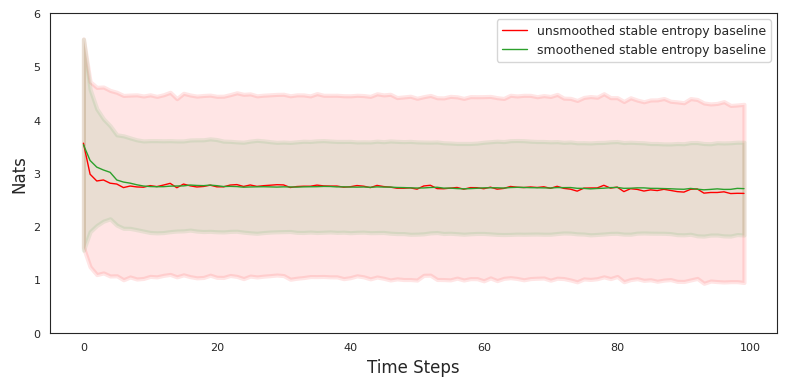

In [41]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)
plot_avg_entropies_mean_std(human_entropies, 'unsmoothed stable entropy baseline', color='red', std_dev=1.0)
plot_avg_entropies_mean_std(human_ma_entropies, 'smoothened stable entropy baseline', std_dev=1.0, ax=ax, color='tab:green', linewidth=1.0)
ax.set_xlabel("Time Steps", fontsize=12)
ax.set_ylabel("Nats", fontsize=12)

## Examples of generation

In [27]:
human_datapoint_idx=2080
human_datapoint = human_dataframe.iloc[human_datapoint_idx]

# human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 40][human_dataframe['model_text'].str.split().apply(len) < 60].sample().iloc[0]
# human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()
print(human_datapoint_idx)
print(human_datapoint.model_text)
print()
print_sample(human_datapoint.context, human_datapoint.model_text)

len(human_datapoint['model_text'])


2080
As a part of these, the 24th Infantry Battalion sent a company across the Hongorai and subsequently located a strong Japanese position on a feature that became known as Egan's Ridge, which, due to its location, commanded the main Australian axis of advance.

As a part of these, the 24th Infantry Battalion sent a company across the Hongorai and subsequently located a strong Japanese position on a feature that became known as Egan's Ridge, which, due to its location, commanded the main Australian axis of advance.


257

In [28]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=WIDTH, max_len=MAX_LEN,
)

Text(0, 0.5, 'Nats')

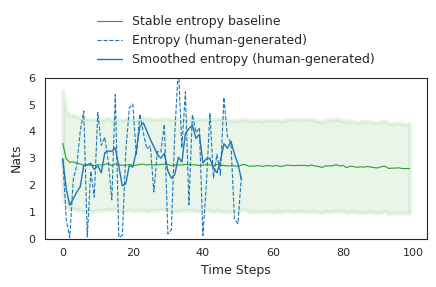

In [36]:
fig, ax = plt.subplots(figsize=(4.5,3), tight_layout=True)
plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=9)    # legend fontsize
plt.rc('axes', labelsize=8)    # fontsize of the x and y labels

plot_avg_entropies_mean_std(human_entropies, 'Stable entropy baseline', ax=ax, color='tab:green', std_dev=STD_DEV, linewidth=0.8)
lpdh.plot(x="index", y='entropy', ax=ax, color='tab:blue', linewidth=0.8, label="Entropy (human-generated)", linestyle='dashed')
lpdh.plot(x="index", y='entropy_ma',  ax=ax, color='tab:blue', linewidth=1.0, label="Smoothed entropy (human-generated)")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=1, title=None, frameon=False)
ax.set_xlabel("Time Steps", fontsize=9)
ax.set_ylabel("Nats", fontsize=9)


In [32]:
# fig, ax = plt.subplots(figsize=(16, 5))
# # lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
# ax2 = ax.twinx()
# ax2.legend(loc=2)
# ax2.set_yscale('log')
# # ax.set_yscale('log')

# ead_v4_labeled_datapoint.plot.bar(x="index", y='rank', ax=ax2, color='lightblue', )
# ead_v4_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:green')
# # typical_labeled_datapoint.plot(x="index", y='probs', ylim=(0,1), ax=ax, color='tab:green')

# ax.set_xticks(np.arange(len(lpdh['index']), step=30))



In [17]:
# fig, ax = plt.subplots(figsize=(16, 5))
# # lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
# ax2 = ax.twinx()
# ax2.legend(loc=2)
# ax2.set_yscale('log')
# # ax.set_yscale('log')

# typical_labeled_datapoint.plot.bar(x="index", y='rank', ax=ax2, color='lightblue', )
# typical_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:green')
# # typical_labeled_datapoint.plot(x="index", y='probs', ylim=(0,1), ax=ax, color='tab:green')

# ax.set_xticks(np.arange(len(lpdh['index']), step=30))



In [18]:
# print((typical_labeled_datapoint['rank'] > 10).sum())
# print((ead_v4_labeled_datapoint['rank'] > 10).sum())


# Entropy of Model Data

In [56]:
model_greedy_dataframe = pd.read_json(gpt2_greedy_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
model_greedy_dataframe.dropna(inplace=True)

model_beam_dataframe = pd.read_json(gpt2_beam_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_temp_dataframe = pd.read_json(gpt2_temp_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

# model_temp_1_dataframe = pd.read_json(gpt2_temp_1_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})

# model_temp_1_5_dataframe = pd.read_json(gpt2_temp_1_5_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})

model_nucleus_dataframe = pd.read_json(gpt2_nucleus_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_topk_dataframe = pd.read_json(gpt2_topk_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_typical_dataframe = pd.read_json(gpt2_typical_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

# model_ead_v4_dataframe = pd.read_json(gpt2_ead_v4_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})

# model_eags_v2_dataframe = pd.read_json(gpt2_eags_v2_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})
                                                 
# model_eags_v3_dataframe = pd.read_json(gpt2_eags_v3_generation, lines=True)\
#                                 .rename(columns={'prefix':'context', 
#                                                  'generation': 'model_text'})
# model_eabs_dataframe = pd.read_csv(gpt2_entropy_beam_generation, sep='\t', names=['context', 'model_text', 'voilations', 'entropies'])


In [119]:
human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 20][human_dataframe['model_text'].str.split().apply(len) < 30].iloc[1]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

print(human_datapoint_idx)

human_datapoint_idx=40

319


/tmp/ipykernel_63299/1718226244.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  human_datapoint = human_dataframe[human_dataframe['model_text'].str.split().apply(len) > 20][human_dataframe['model_text'].str.split().apply(len) < 30].iloc[1]


In [120]:
human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe[model_greedy_dataframe.context == human_datapoint.context].iloc[0]
beam_sample = model_beam_dataframe[model_beam_dataframe.context == human_datapoint.context].iloc[0]
temp_sample = model_temp_dataframe[model_temp_dataframe.context == human_datapoint.context].iloc[0]
# temp_1_sample = model_temp_1_dataframe[model_temp_1_dataframe.context == human_datapoint.context].iloc[0]
# temp_1_5_sample = model_temp_1_5_dataframe[model_temp_1_5_dataframe.context == human_datapoint.context].iloc[0]

nucleus_sample = model_nucleus_dataframe[model_nucleus_dataframe.context == human_datapoint.context].iloc[0]
topk_sample = model_topk_dataframe[model_topk_dataframe.context == human_datapoint.context].iloc[0]
typical_sample = model_typical_dataframe[model_typical_dataframe.context == human_datapoint.context].iloc[0]
# ead_v4_sample = model_ead_v4_dataframe.iloc[human_datapoint_idx]
# eag_v2_sample = model_eags_v2_dataframe.iloc[human_datapoint_idx]
# eag_v3_sample = model_eags_v3_dataframe.iloc[human_datapoint_idx]

# eabs_sample = model_eabs_dataframe.iloc[human_datapoint_idx * 10]

print("Context:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text)
print()
print("Beam Model Text: ")
print_sample(human_datapoint.context, beam_sample.model_text)
print()
print("Temperature 0.8 sampled Model Text:")
print_sample(human_datapoint.context, temp_sample.model_text)
print()

# print("Temperature 1.0 sampled Model Text:")
# print_sample(human_datapoint.context, temp_1_sample.model_text)
# print()
# print("Temperature 1.5 sampled Model Text:")
# print_sample(human_datapoint.context, temp_1_5_sample.model_text)
# print()
print("Nucleus sampled Model Text:")
print_sample(human_datapoint.context, nucleus_sample.model_text)
print()
print("Top-K sampled Model Text:")
print_sample(human_datapoint.context, topk_sample.model_text)
print()

print("Typical Model Text: ")
print_sample(human_datapoint.context, typical_sample.model_text)
print()

# print("EAD Model Text:")
# print_sample(human_datapoint.context, ead_v4_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EAG Model V2 Text:")
# print_sample(human_datapoint.context, eag_v2_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EAG Model V3 Text:")
# print_sample(human_datapoint.context, eag_v3_sample.model_text)
# # print(f"Num. Voilations: {eag_sample.voilations}")
# print()

# print("EABS Model Text:")
# print_sample(human_datapoint.context, eabs_sample.model_text.replace("\n", "\\n"))
# print(f"Num. Voilations: {eabs_sample.voilations}")
# print()

Context:
Farrell explained the motivation he gave to the character, stating "This guy thinks he's God's gift to women, God's gift to intellect, to humor, to the club scene, to everything. It's all part of his grandiose sense of self-esteem, which is probably masking a deeper sense of being a disappointment to his father and being riddled with envy over the relationship his father had with Kurt, and all kinds of other things. With Pellit, Seth gave me complete license to act as pathologically screwed up as possible." Farrell contributed significantly to the appearance of his character, suggesting the comb over hairstyle, pot-belly and an affinity for Chinese dragons. The character had the more "colorful" name "Cocksucker Jones", but it was changed to "Motherfucker Jones" at Foxx's request, with producer Jay Stern commenting that Foxx felt it "was over the line".

Target:
The current name was said to be subject to further change, prior to the release of the film. Foxx contributed to his 

In [57]:
typical_sample.model_text = "Michigan Department of Transportation letters to Congress, dated 18 November 1947 and 3 June 1948, approved the abandonment of the business US 2 segment of US 2 in favor of an expanded US 12. Approximately 3.5 miles of US 12 was completed between Ann Arbor and Sault Ste. Marie between 1964 and 1965"

In [107]:
lpdh

,index,token,is_rep,is_lrep,is_crep,entropy,entropy_ma,dent,ddent,dddent,probs,rank
0,0,The,0,0,0,6.867188,6.867188,0.000000,0.000000,0.000000,0.002748,34
1,1,Ġprimary,0,0,0,4.718750,5.792969,0.000000,0.000000,0.000000,0.258545,0
2,2,Ġfocus,0,0,0,0.220459,3.935547,0.000000,0.000000,0.000000,0.969727,0
3,3,Ġof,0,0,0,1.328125,3.283203,0.000000,0.000000,0.000000,0.694824,0
4,4,Ġhis,0,0,0,3.693359,3.365234,0.000000,0.000000,0.000000,0.198364,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58,58,ĠChick,0,0,0,0.000418,1.829102,-2.621094,-0.542969,0.962891,1.000000,0
59,59,ens,0,0,0,1.180664,0.858887,-3.187500,-0.566406,-0.023438,0.767090,0
60,60,"""",0,0,0,2.927734,1.007812,-3.714844,-0.527344,0.039062,0.003258,24
61,61,Ġgained,0,0,0,3.572266,1.666016,-2.400391,1.314453,1.841797,0.049744,6


Text(0.5, 0, 'Time Steps')

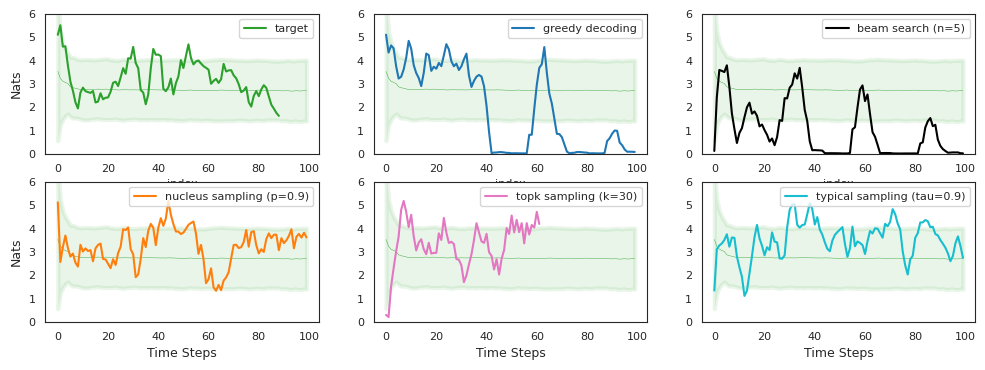

In [ ]:
STD_DEV=1.5
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)[:100]

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)[:100]

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)[:100]

temp_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)[:100]

# temp_1_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=temp_1_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )
# temp_1_5_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=temp_1_5_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )
nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)[:100]

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)[:100]

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)[:100]

# ead_v4_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=ead_v4_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v2_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eag_v2_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v3_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=eag_v3_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

fig, axs = plt.subplots(2,3, figsize=(12, 4))
plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0,0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='Human-generated', color='tab:green')
axs[0,0].legend(fontsize=8, loc="upper right")
axs[0,0].tick_params(labelsize=8)
axs[0,0].set_ylabel("Nats", fontsize=9)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[0,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,1], label='Greedy decoding', color='tab:blue')
axs[0,1].legend(fontsize=8, loc="upper right")
axs[0,1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0,2], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,2], label='Beam search (n=5)', color='black')
axs[0,2].legend(fontsize=8, loc="upper right")
axs[0,2].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1,0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,0], label='Nucleus sampling (p=0.9)', color='tab:orange')
axs[1,0].legend(fontsize=8, loc="upper right")
axs[1,0].tick_params(labelsize=8)
axs[1,0].set_xlabel("Time Steps", fontsize=9)
axs[1,0].set_ylabel("Nats", fontsize=9)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,1], label='Top-k sampling (k=30)', color='tab:pink')
axs[1,1].legend(fontsize=8, loc="upper right")
axs[1,1].tick_params(labelsize=8)
axs[1,1].set_xlabel("Time Steps", fontsize=9)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1,2], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,2], label='Typical sampling (tau=0.9)', color='tab:cyan')
axs[1,2].legend(fontsize=8, loc="upper right")
axs[1,2].tick_params(labelsize=8)
axs[1,2].set_xlabel("Time Steps", fontsize=9)
# plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[3,0],  color='tab:green', std_dev=STD_DEV, linewidth=0.3)
# temp_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 0], label='temp. sampling (temp=0.8)', color='tab:red')
# axs[3, 0].legend(fontsize=8, loc="upper right")
# axs[3, 0].tick_params(labelsize=8)

# plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[3,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
# ead_v4_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 1], label='Entropy Aware Decoding', color='tab:olive')
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

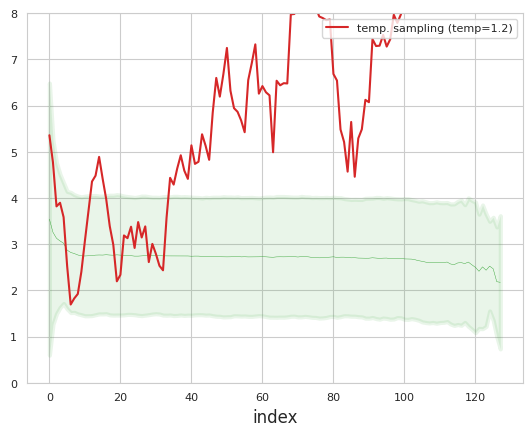

In [23]:
ax = plot_avg_entropies_mean_std(human_ma_entropies,  color='tab:green', std_dev=STD_DEV, linewidth=0.3)
temp_1_5_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=ax, label='temp. sampling (temp=1.2)', color='tab:red')
ax.legend(fontsize=8, loc="upper right")
ax.tick_params(labelsize=8)

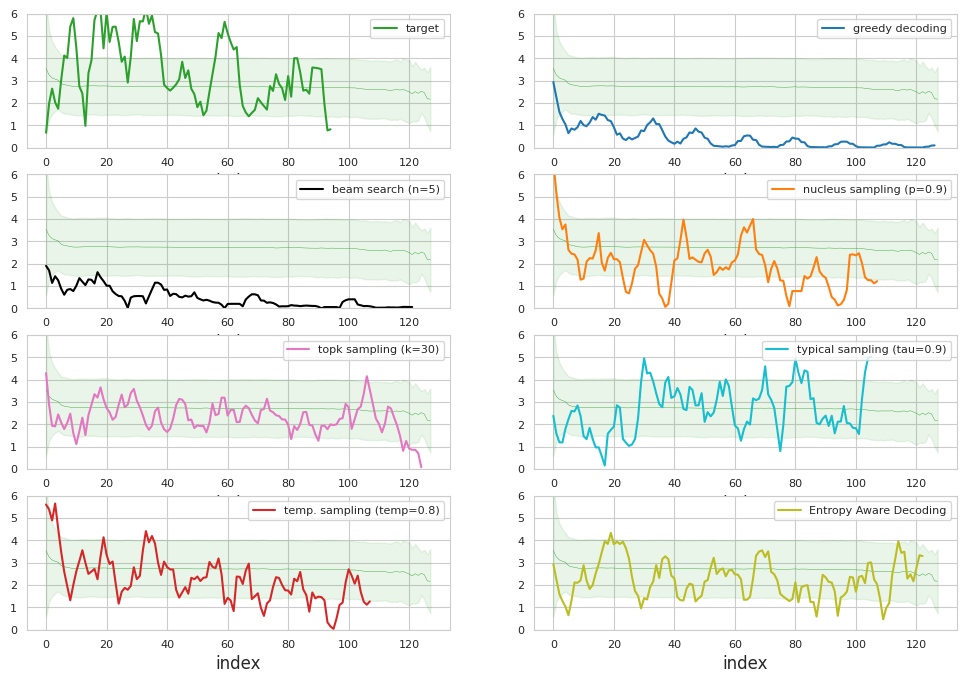

In [51]:
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
# lpdh['surprisal'] = lpdh.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()
lpdh['surprisal'] = moving_average(lpdh.probs.apply(lambda x: -1 * np.log(x)), 5)

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
# greedy_labeled_datapoint['surprisal'] = greedy_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()
greedy_labeled_datapoint['surprisal'] = moving_average(greedy_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
beam_labeled_datapoint['surprisal'] = moving_average(beam_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

temp_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
temp_labeled_datapoint['surprisal'] = moving_average(temp_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
nucleus_labeled_datapoint['surprisal'] = moving_average(nucleus_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
topk_labeled_datapoint['surprisal'] = moving_average(topk_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
typical_labeled_datapoint['surprisal'] = moving_average(typical_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

ead_v4_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
ead_v4_labeled_datapoint['surprisal'] = moving_average(ead_v4_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)), 5)

fig, axs = plt.subplots(4,2, figsize=(12, 8))
plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0, 0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
lpdh.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
axs[0,0].legend(fontsize=8, loc="upper right")
axs[0,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[0, 1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
axs[0, 1].legend(fontsize=8, loc="upper right")
axs[0, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1, 0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[1, 0], label='beam search (n=5)', color='black')
axs[1, 0].legend(fontsize=8, loc="upper right")
axs[1, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1, 1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
nucleus_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling (p=0.9)', color='tab:orange')
axs[1, 1].legend(fontsize=8, loc="upper right")
axs[1, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[2,0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
topk_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[2,0], label='topk sampling (k=30)', color='tab:pink')
axs[2,0].legend(fontsize=8, loc="upper right")
axs[2,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[2,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
typical_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[2,1], label='typical sampling (tau=0.9)', color='tab:cyan')
axs[2,1].legend(fontsize=8, loc="upper right")
axs[2,1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[3,0],  color='tab:green', std_dev=STD_DEV, linewidth=0.3)
temp_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[3, 0], label='temp. sampling (temp=0.8)', color='tab:red')
axs[3, 0].legend(fontsize=8, loc="upper right")
axs[3, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[3,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
ead_v4_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6), ax=axs[3, 1], label='Entropy Aware Decoding', color='tab:olive')
axs[3, 1].legend(fontsize=8, loc="upper right")
axs[3, 1].tick_params(labelsize=8)

<AxesSubplot: xlabel='index'>

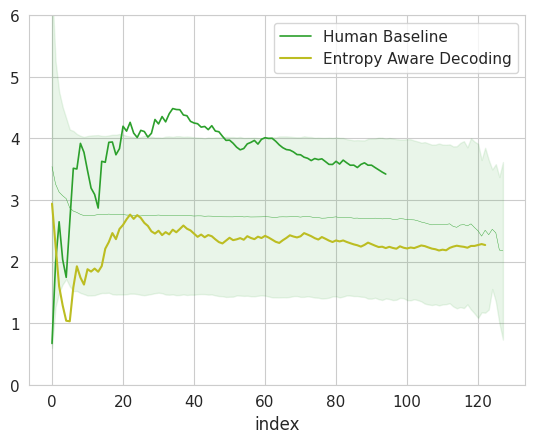

In [38]:
fig, ax = plt.subplots()
lpdh['surprisal'] = lpdh.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()
plot_avg_entropies_mean_std(human_ma_entropies, color='tab:green', std_dev=STD_DEV, linewidth=0.3)

lpdh.plot(x="index", y='surprisal',ylim=(0,6), ax=ax, label='Human Baseline', color='tab:green', linewidth=1.2)
ead_v4_labeled_datapoint['surprisal'] = ead_v4_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()
ead_v4_labeled_datapoint.plot(x="index", y='surprisal', ax=ax, ylim=(0,6),  label='Entropy Aware Decoding', color='tab:olive')
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

<AxesSubplot: xlabel='index'>

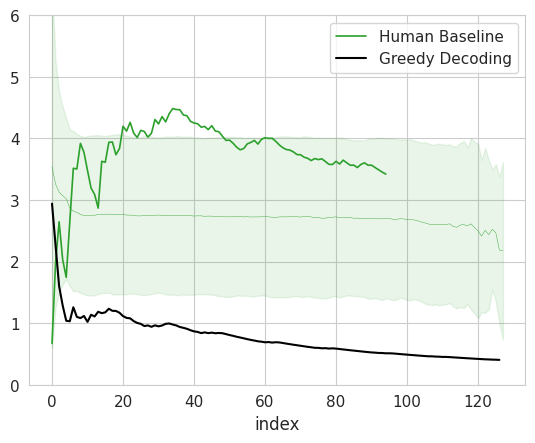

In [39]:
fig, ax = plt.subplots()
lpdh['surprisal'] = lpdh.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()
lpdh['entropy_cumsum'] = lpdh.entropy.expanding().mean()

lpdh.plot(x="index", y='surprisal',ylim=(0,6), ax=ax, label='Human Baseline', color='tab:green', linewidth=1.2)
# lpdh.plot(x="index", y='entropy_cumsum',ylim=(0,6), ax=ax, label='Human Baseline', color='tab:blue', linewidth=1.2)

greedy_labeled_datapoint['surprisal'] = greedy_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()

plot_avg_entropies_mean_std(human_ma_entropies, color='tab:green', ax=ax, std_dev=STD_DEV, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='surprisal', ax=ax, ylim=(0,6),  label='Greedy Decoding', color='black')

<AxesSubplot: xlabel='index'>

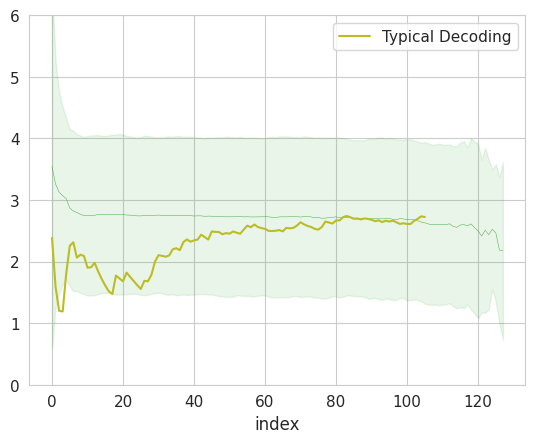

In [40]:
fig, ax = plt.subplots()

typical_labeled_datapoint['surprisal'] = typical_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()

plot_avg_entropies_mean_std(human_ma_entropies, color='tab:green', std_dev=STD_DEV, linewidth=0.3, ax=ax)
typical_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6),  label='Typical Decoding', color='tab:olive', ax=ax)
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

<AxesSubplot: xlabel='index'>

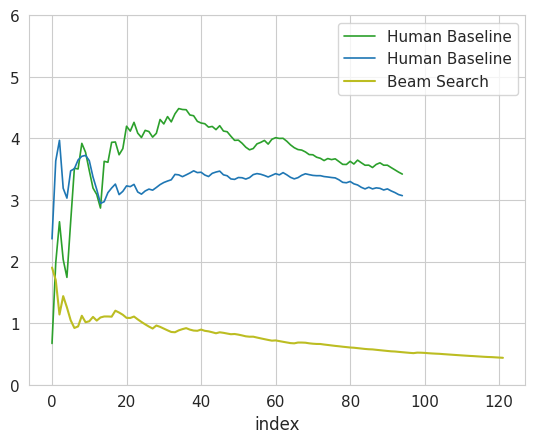

In [41]:
fig, ax = plt.subplots()
lpdh['surprisal'] = lpdh.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()
lpdh['entropy_cumsum'] = lpdh.entropy.expanding().mean()

lpdh.plot(x="index", y='surprisal',ylim=(0,6), ax=ax, label='Human Baseline', color='tab:green', linewidth=1.2)
lpdh.plot(x="index", y='entropy_cumsum',ylim=(0,6), ax=ax, label='Human Baseline', color='tab:blue', linewidth=1.2)

beam_labeled_datapoint['surprisal'] = beam_labeled_datapoint.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()

# ax = plot_avg_entropies_mean_std(human_ma_entropies, color='tab:green', std_dev=STD_DEV, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='surprisal', ylim=(0,6),  ax=ax, label='Beam Search', color='tab:olive')
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

<AxesSubplot: xlabel='index'>

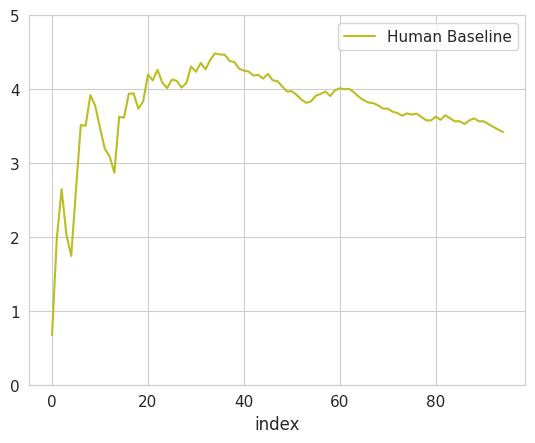

In [61]:
lpdh['surprisal'] = lpdh.probs.apply(lambda x: -1 * np.log(x)).expanding().mean()

# ax = plot_avg_entropies_mean_std(human_ma_entropies, color='tab:green', std_dev=STD_DEV, linewidth=0.3)
lpdh.plot(x="index", y='surprisal',ylim=(0,5), label='Human Baseline', color='tab:olive')
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

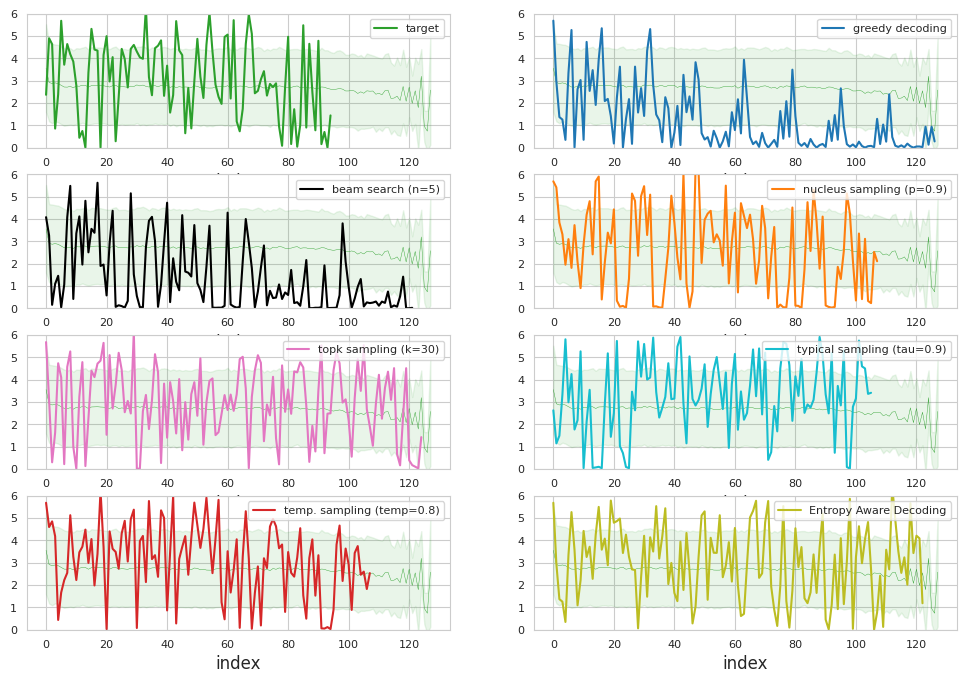

In [26]:
STD_DEV=1.0
lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

temp_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

ead_v4_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

# eag_v2_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eag_v2_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v3_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=eag_v3_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

fig, axs = plt.subplots(4,2, figsize=(12, 8))
plot_avg_entropies_mean_std(human_entropies,  ax=axs[0, 0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
lpdh.plot(x="index", y='entropy', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
axs[0,0].legend(fontsize=8, loc="upper right")
axs[0,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies, ax=axs[0, 1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
axs[0, 1].legend(fontsize=8, loc="upper right")
axs[0, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies,  ax=axs[1, 0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[1, 0], label='beam search (n=5)', color='black')
axs[1, 0].legend(fontsize=8, loc="upper right")
axs[1, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies,  ax=axs[1, 1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
nucleus_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[1, 1], label='nucleus sampling (p=0.9)', color='tab:orange')
axs[1, 1].legend(fontsize=8, loc="upper right")
axs[1, 1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies,  ax=axs[2,0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
topk_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[2,0], label='topk sampling (k=30)', color='tab:pink')
axs[2,0].legend(fontsize=8, loc="upper right")
axs[2,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies,  ax=axs[2,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
typical_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[2,1], label='typical sampling (tau=0.9)', color='tab:cyan')
axs[2,1].legend(fontsize=8, loc="upper right")
axs[2,1].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies,  ax=axs[3,0],  color='tab:green', std_dev=STD_DEV, linewidth=0.3)
temp_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[3, 0], label='temp. sampling (temp=0.8)', color='tab:red')
axs[3, 0].legend(fontsize=8, loc="upper right")
axs[3, 0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_entropies, ax=axs[3,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
ead_v4_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=axs[3, 1], label='Entropy Aware Decoding', color='tab:olive')
axs[3, 1].legend(fontsize=8, loc="upper right")
axs[3, 1].tick_params(labelsize=8)

In [74]:
gpt2_ead_v4_0_5_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_0.5_till_5_patience_5_run_2_ea_donot_intervene_for_upper_bound.jsonl"
gpt2_ead_v4_0_8_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_0.8_till_5_patience_5_run_2_ea_donot_intervene_for_upper_bound.jsonl"
gpt2_ead_v4_1_0_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_1.0_till_5_patience_5_run_2_ea_donot_intervene_for_upper_bound.jsonl"
gpt2_ead_v4_0_8_0_3_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_0.8_till_0_patience_3_run_1_ea_donot_intervene_for_upper_bound.jsonl"

gpt2_ead_v4_0_8_0_2_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_0.8_till_0_patience_2_run_1_ea_donot_intervene_for_upper_bound.jsonl"

gpt2_ead_v4_0_8_0_3_2_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_0.8_till_0_patience_3_run_2_ea_donot_intervene_for_upper_bound.jsonl"
gpt2_ead_v4_0_8_0_3_2_bs_4_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v4_eas_std_dev_0.8_till_0_patience_3_run_2_bs_4_ea_donot_intervene_for_upper_bound_backoff.jsonl"

gpt2_ead_v5_0_8_0_3_lower_only_generation = "/home/mila/a/arorakus/wdir/entropy_aware_search/data/wiki_rankgen/generated/gpt2_xl/v4_sampling_analysis_5//eags_v5_eas_std_dev_0.8_till_0_patience_3_run_2_ea_donot_intervene_for_upper_bound.jsonl"

model_ead_v4_0_5_lower_only_generation = pd.read_json(gpt2_ead_v4_0_5_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})


model_ead_v4_0_8_lower_only_generation = pd.read_json(gpt2_ead_v4_0_8_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_ead_v4_1_0_lower_only_generation = pd.read_json(gpt2_ead_v4_1_0_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})


model_ead_v4_0_8_0_3_lower_only_generation = pd.read_json(gpt2_ead_v4_0_8_0_3_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_ead_v5_0_8_0_3_lower_only_generation = pd.read_json(gpt2_ead_v5_0_8_0_3_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})
                                                 
model_ead_v4_0_8_0_3_2_lower_only_generation = pd.read_json(gpt2_ead_v4_0_8_0_3_2_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})

model_ead_v4_0_8_0_3_2_bs_4_lower_only_generation = pd.read_json(gpt2_ead_v4_0_8_0_3_2_bs_4_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})


model_ead_v4_0_8_0_2_lower_only_generation = pd.read_json(gpt2_ead_v4_0_8_0_2_lower_only_generation, lines=True)\
                                .rename(columns={'prefix':'context', 
                                                 'generation': 'model_text'})


Context:
The storm's remnants persisted for several more hours before dissipating roughly 175 mi (280 km) southwest of Cabo Corrientes, Jalisco. Following the classification of Tropical Depression Two-E on June 19, the Government of Mexico issued a tropical storm warning for coastal areas between Zihuatanejo and Manzanillo. A hurricane watch was also put in place from Tecpán de Galeana to Punta San Telmo. Later that day, the tropical storm warning was upgraded to a hurricane warning and the watch was extended westward to La Fortuna. As Beatriz continued to strengthen, the watches and warnings were extended westward to Cabo Corrientes on June 20. Early on June 21, the easternmost advisories were discontinued as Beatriz moved away. Later that morning, all watches and warnings were discontinued in light of Beatriz's rapid weakening. In Colima and Jalisco, residents were warned of heavy rains that could trigger flooding and mudslides. Schools across both states canceled classes for June 21

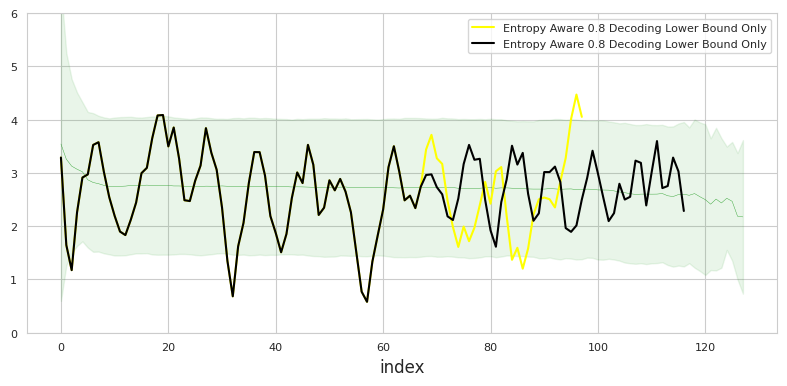

In [98]:
human_datapoint_idx=28
human_datapoint = human_dataframe.iloc[human_datapoint_idx]

print("Context:")
print(human_datapoint.context)
print()
print("Target:")
print(human_datapoint.model_text)
print()

ead_v4_0_5_lower_only_generation_sample = model_ead_v4_0_5_lower_only_generation.iloc[human_datapoint_idx]
ead_v4_0_8_lower_only_generation_sample = model_ead_v4_0_8_lower_only_generation.iloc[human_datapoint_idx]
ead_v4_1_0_lower_only_generation_sample = model_ead_v4_1_0_lower_only_generation.iloc[human_datapoint_idx]
ead_v4_0_8_0_3_lower_only_generation_sample = model_ead_v4_0_8_0_3_lower_only_generation.iloc[human_datapoint_idx]
ead_v4_0_8_0_2_lower_only_generation_sample = model_ead_v4_0_8_0_2_lower_only_generation.iloc[human_datapoint_idx]
ead_v4_0_8_0_3_2_lower_only_generation_sample = model_ead_v4_0_8_0_3_2_lower_only_generation.iloc[human_datapoint_idx]
ead_v5_0_8_0_3_lower_only_generation_sample = model_ead_v5_0_8_0_3_lower_only_generation.iloc[human_datapoint_idx]
ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample = model_ead_v4_0_8_0_3_2_bs_4_lower_only_generation.iloc[human_datapoint_idx]

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text)
print()

print("EAD Lower 0.5 Model Text:")
print_sample(human_datapoint.context, ead_v4_0_5_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAD Lower 0.8 Model Text:")
print_sample(human_datapoint.context, ead_v4_0_8_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()


print("EAD Lower 1.0 Model Text:")
print_sample(human_datapoint.context, ead_v4_1_0_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()


print("EAD Lower 0.8 0 3 Model Text:")
print_sample(human_datapoint.context, ead_v4_0_8_0_3_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAD Lower V5 0.8 0 3 Model Text:")
print_sample(human_datapoint.context, ead_v5_0_8_0_3_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAD Lower 0.8 0 3 2 Model Text:")
print_sample(human_datapoint.context, ead_v4_0_8_0_3_2_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAD Lower 0.8 0 3 2 BS 4 Model Text:")
print_sample(human_datapoint.context, ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAD Lower 0.8 0 2 Model Text:")
print_sample(human_datapoint.context, ead_v4_0_8_0_2_lower_only_generation_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()

print("EAD Model Text:")
print_sample(human_datapoint.context, ead_v4_sample.model_text)
# print(f"Num. Voilations: {eag_sample.voilations}")
print()


ead_v4_0_5_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_0_5_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

ead_v4_0_8_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_0_8_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

ead_v4_1_0_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_1_0_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


ead_v4_0_8_0_3_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_0_8_0_3_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

ead_v5_0_8_0_3_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v5_0_8_0_3_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

ead_v4_0_8_0_3_2_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_0_8_0_3_2_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)


ead_v4_0_8_0_2_lower_only_generation_sample = process_datapoint(
    model=gpt2_model, datapoint=ead_v4_0_8_0_2_lower_only_generation_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

ax = plot_avg_entropies_mean_std(human_ma_entropies,  color='tab:green', std_dev=1.5, linewidth=0.3)
# lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='target', color='tab:pink')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='greedy decoding', color='tab:blue')
# ead_v4_0_5_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.5 Decoding Lower Bound Only', color='tab:red')
# ead_v4_0_8_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.8 Decoding Lower Bound Only', color='tab:green')
# ead_v4_0_8_0_3_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.8 Decoding Lower Bound Only', color='tab:cyan')
# ead_v5_0_8_0_3_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.8 Decoding Lower Bound Only', color='tab:red')

# ead_v4_0_8_0_2_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.8 Decoding Lower Bound Only', color='tab:brown')
ead_v4_0_8_0_3_2_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.8 Decoding Lower Bound Only', color='yellow')
ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 0.8 Decoding Lower Bound Only', color='black')

# ead_v4_1_0_lower_only_generation_sample.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware 1.0 Decoding Lower Bound Only', color='tab:orange')
# ead_v4_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=ax, label='Entropy Aware Decoding', color='tab:olive')
ax.legend(fontsize=8, loc="upper right")
ax.tick_params(labelsize=8)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


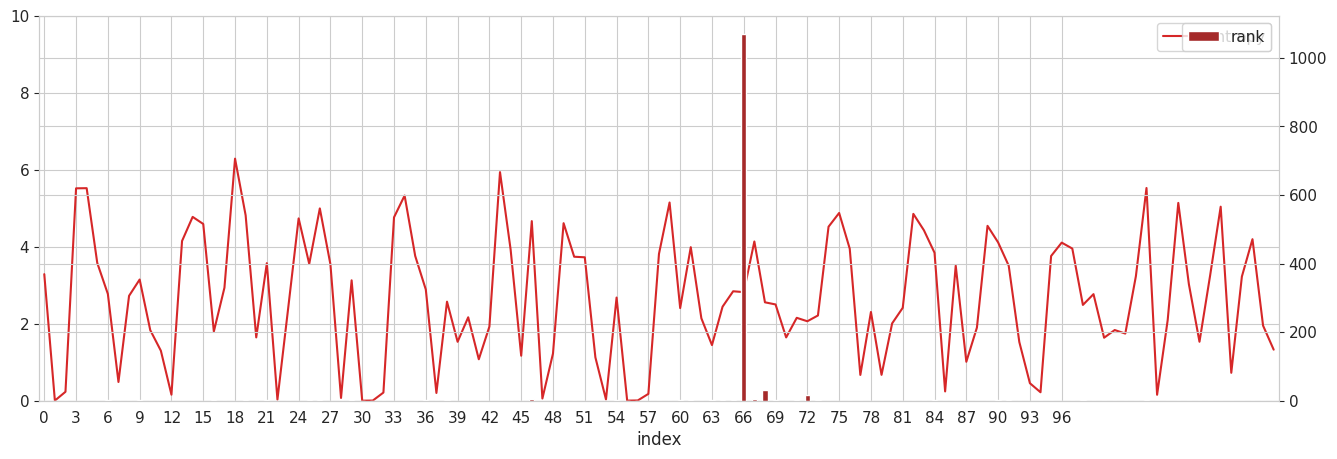

In [99]:
fig, ax = plt.subplots(figsize=(16, 5))
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2 = ax.twinx()
ax2.legend(loc=2)
# ax2.set_yscale('log')
# ax.set_yscale('log')
# plot_avg_entropies_mean_std(human_ma_entropies, ax=ax, color='tab:green', std_dev=0.8, linewidth=0.3)

# ead_v4_0_8_0_3_2_lower_only_generation_sample.plot.bar(x="index", y='rank', ax=ax2, color='blue', )
ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample.plot.bar(x="index", y='rank', ax=ax2, color='brown', )

# ead_v4_0_8_0_3_2_lower_only_generation_sample.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:green')
ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:red')

# greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=ax, label='greedy decoding', color='tab:blue')
# typical_labeled_datapoint.plot(x="index", y='probs', ylim=(0,1), ax=ax, color='tab:green')

car=ax.set_xticks(np.arange(len(ead_v4_0_8_0_3_2_lower_only_generation_sample['index']), step=3))



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


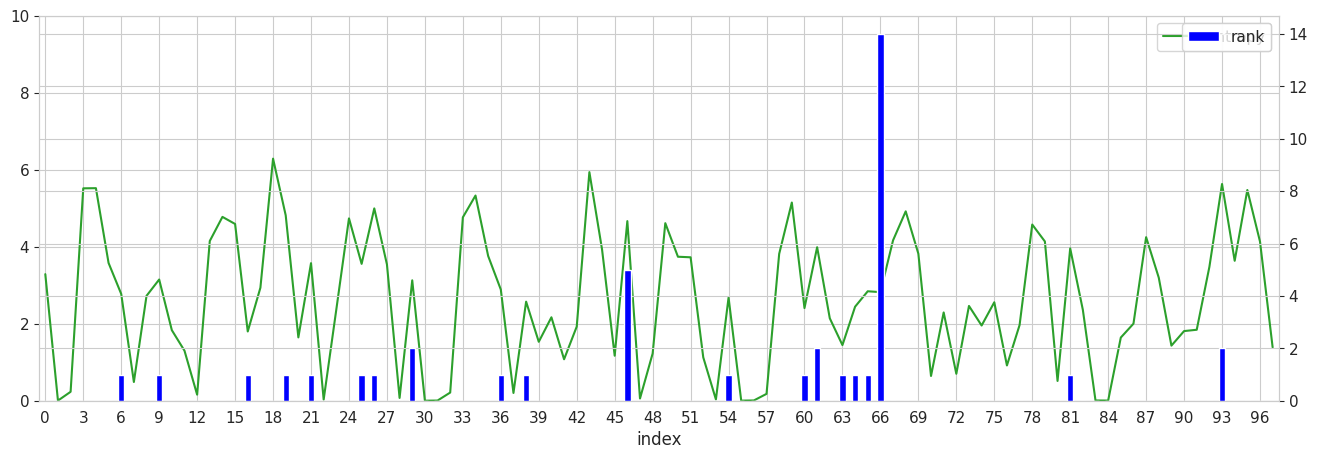

In [100]:
fig, ax = plt.subplots(figsize=(16, 5))
# lpdh.plot.bar(x='index', y='is_lrep', ax=ax2, fill=True, rot='60')
ax2 = ax.twinx()
ax2.legend(loc=2)
# ax2.set_yscale('log')
# ax.set_yscale('log')
# plot_avg_entropies_mean_std(human_ma_entropies, ax=ax, color='tab:green', std_dev=0.8, linewidth=0.3)

ead_v4_0_8_0_3_2_lower_only_generation_sample.plot.bar(x="index", y='rank', ax=ax2, color='blue', )
# ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample.plot.bar(x="index", y='rank', ylim=(0, 25),  ax=ax2, color='brown', )

ead_v4_0_8_0_3_2_lower_only_generation_sample.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:green')
# ead_v4_0_8_0_3_2_bs_4_lower_only_generation_sample.plot(x="index", y='entropy', ylim=(0,10), ax=ax, color='tab:red')

# greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,6), ax=ax, label='greedy decoding', color='tab:blue')
# typical_labeled_datapoint.plot(x="index", y='probs', ylim=(0,1), ax=ax, color='tab:green')

car=ax.set_xticks(np.arange(len(ead_v4_0_8_0_3_2_lower_only_generation_sample['index']), step=3))



In [28]:
ead_v4_0_5_lower_only_generation_sample[['rank', 'token', 'entropy']][:40]

,rank,token,entropy
0,1,The,5.688130
1,0,Ġwestern,2.957329
2,0,Ġsection,1.370358
3,0,Ġof,1.257270
4,0,ĠUS,0.347874
5,0,Ġ2,3.346885
6,0,Ġwas,5.269953
7,0,Ġren,0.007219
8,0,umbered,2.618861
9,0,Ġas,3.029639


In [29]:
greedy_labeled_datapoint[['rank', 'token', 'entropy']][:40]

,rank,token,entropy
0,1,The,5.688130
1,0,Ġwestern,2.957329
2,0,Ġsection,1.370356
3,0,Ġof,1.257271
4,0,ĠUS,0.347874
5,0,Ġ2,3.346887
6,0,Ġwas,5.269953
7,0,Ġren,0.007219
8,0,umbered,2.618860
9,0,Ġas,3.029641


In [30]:
greedy_labeled_datapoint

,index,token,is_rep,is_lrep,is_crep,entropy,entropy_ma,dent,ddent,dddent,probs,rank
0,0,The,0,0,0,5.688130,5.688130,0.000000,0.000000,0.000000,0.052909,1
1,1,Ġwestern,0,0,0,2.957329,4.322730,0.000000,0.000000,0.000000,0.205879,0
2,2,Ġsection,1,0,1,1.370356,3.338605,0.000000,0.000000,0.000000,0.758568,0
3,3,Ġof,1,0,1,1.257271,2.818272,0.000000,0.000000,0.000000,0.701543,0
4,4,ĠUS,1,0,1,0.347874,2.324192,0.000000,0.000000,0.000000,0.959148,0
...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,ĠM,1,1,1,0.023804,0.037807,-0.104496,0.443714,0.403403,0.997035,0
123,123,âĢĳ,1,1,1,0.939023,0.213185,0.130145,0.234641,-0.209073,0.831867,0
124,124,28,1,1,1,0.132226,0.239474,0.161348,0.031203,-0.203439,0.986172,0
125,125,Ġin,1,1,0,0.935165,0.416339,0.344137,0.182789,0.151586,0.772863,0


AttributeError: 'str' object has no attribute 'yaxis'

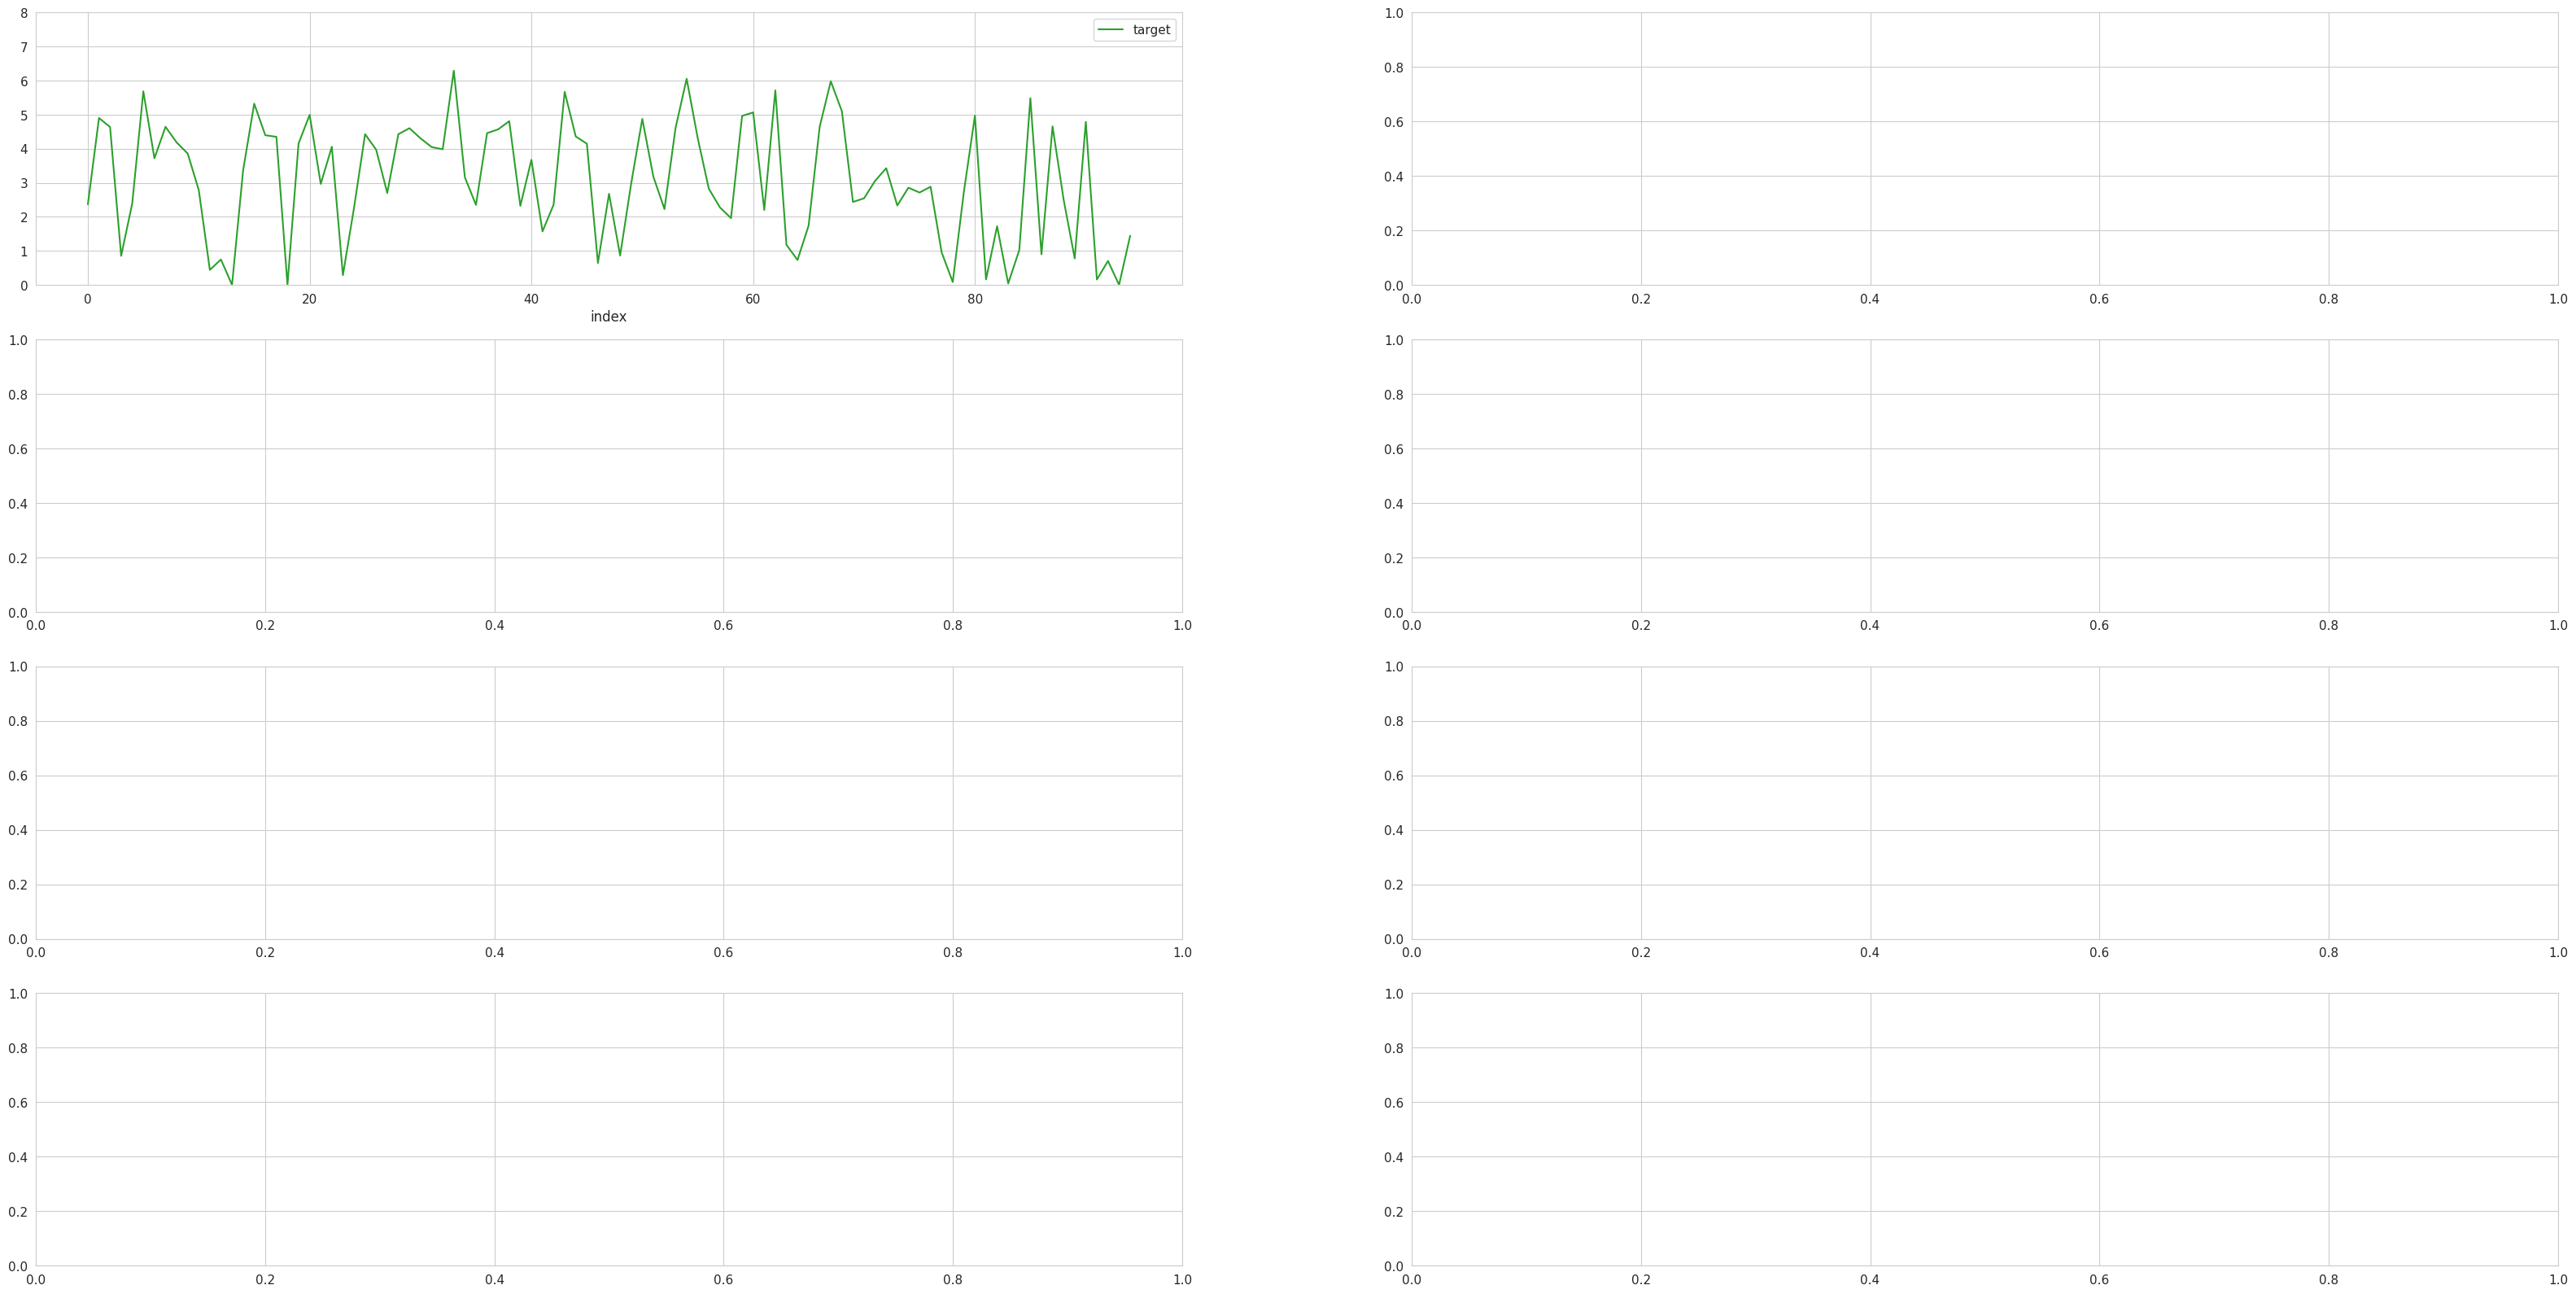

In [31]:
fig, axs = plt.subplots(4,2, figsize=(40, 20))
# plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)

lpdh.plot(x="index", y='entropy', ylim=(0,8), ax=axs[0,0], label='target', color='tab:green')
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)

ax2 = axs[0,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
lpdh.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

greedy_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[0, 1], label='greedy decoding', color='tab:blue')
plot_avg_entropies_mean_std(human_ma_entropies, axs[0, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[0,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
greedy_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

beam_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[1, 0], label='beam search', color='black')
plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[1,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
beam_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

nucleus_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[1, 1], label='nucleus sampling', color='tab:orange')
plot_avg_entropies_mean_std(human_ma_entropies, axs[1, 1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[1,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
nucleus_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

topk_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[2,0], label='topk sampling', color='tab:pink')
plot_avg_entropies_mean_std(human_ma_entropies, axs[2,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[2,0].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
topk_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')


typical_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[2,1], label='typical sampling', color='tab:cyan')
plot_avg_entropies_mean_std(human_ma_entropies, axs[2,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
ax2 = axs[2,1].twinx()
ax2.legend(loc=2)
ax2.set_ylim((0,10))
# ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
typical_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

# eag_v2_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[3,0], label='EAGS V2', color='tab:cyan', linestyle='dashed')
# eag_v2_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=axs[3,0], label='EAGS V2', color='tab:cyan')
# plot_avg_entropies_mean_std(human_ma_entropies, axs[3,0], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
# ax2 = axs[3,0].twinx()
# ax2.legend(loc=2)
# ax2.set_ylim((0,10))
# # ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
# eag_v2_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')


# eag_v3_labeled_datapoint.plot(x="index", y='entropy', ylim=(0,8), ax=axs[3,1], label='EAGS V3', color='tab:cyan', linestyle='dashed')
# eag_v3_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,8), ax=axs[3,1], label='EAGS V3', color='tab:cyan')

# plot_avg_entropies_mean_std(human_ma_entropies, axs[3,1], 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=0.1)
# ax2 = axs[3,1].twinx()
# ax2.legend(loc=2)
# ax2.set_ylim((0,10))
# # ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90, ha='right')
# eag_v3_labeled_datapoint.plot.bar(x="index", y='rank',  ax=ax2, label='rank', color='lightblue')

plt.setp(axs, xticks=range(0, MAX_LEN, 5))


## Generate using Entropy Aware Greedy Search

In [ ]:
%%script false --no-raise-error

tokenizer.pad_token = tokenizer.eos_token

tokenized_context = tokenizer(human_datapoint.context, return_tensors="pt")
tokenized_context = tokenized_context.to('cuda')

gpt2_model.greedy_search(**tokenized_context, max_length=1024, pad_token_id=tokenizer.eos_token_id)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
%%script false --no-raise-error
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
test_dataloader = DataLoader(tokenized_writing_prompt_testset, collate_fn=data_collator, batch_size=1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Compute Average entropy across timesteps.

### For all model generated data

In [124]:
# Greedy
model_gen_greedy_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

# model_gen_greedy_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_greedy_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_greedy', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

5000it [04:37, 18.02it/s]

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/467b46c864f5786bdcbb0ec4bff063da-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_greedy-100-5000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/467b46c864f5786bdcbb0ec4bff063da-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_greedy-100-5000-entropy-1-avgs.csv


In [125]:
# Beam
model_gen_beam_avg_entropy_pd, model_gen_greedy_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

# model_gen_beam_avg_ma_entropy_pd, model_gen_greedy_ma_entropies = compute_average_across_sequences(model_beam_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_beam', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

5000it [04:21, 19.13it/s]

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/6e908b7c86fbd6a49831b9f81946606e-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_beam-100-5000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/6e908b7c86fbd6a49831b9f81946606e-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_beam-100-5000-entropy-1-avgs.csv


In [126]:
# Nucleus
model_gen_nucleus_avg_entropy_pd, model_gen_nucleus_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

# model_gen_nucleus_avg_ma_entropy_pd, model_gen_nucleus_ma_entropies = compute_average_across_sequences(model_nucleus_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_nucleus', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


5000it [04:29, 18.55it/s]

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/2a543fcbc71fc43f045edfa1bef57207-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_nucleus-100-5000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/2a543fcbc71fc43f045edfa1bef57207-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_nucleus-100-5000-entropy-1-avgs.csv


In [127]:
# Topk
model_gen_topk_avg_entropy_pd, model_gen_topk_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

# model_gen_topk_avg_ma_entropy_pd, model_gen_topk_ma_entropies = compute_average_across_sequences(model_topk_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_topk', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)


5000it [04:28, 18.62it/s]

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/ad4582d8cb806e5eb77a78598d03df30-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_topk-100-5000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/ad4582d8cb806e5eb77a78598d03df30-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_topk-100-5000-entropy-1-avgs.csv


In [128]:
# Typical Decoding
model_gen_typical_avg_entropy_pd, model_gen_typical_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_search',  max_len=MAX_LEN, num_seq=NUM_SEQ, cache=True)

# model_gen_typical_avg_ma_entropy_pd, model_gen_typical_ma_entropies = compute_average_across_sequences(model_typical_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_typical_decoding', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

5000it [04:30, 18.48it/s]

Saving to:
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/48006cd7c3dd711c730196335e97373f-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_typical_search-100-5000-entropy-1-ndarray.npy, and
	/home/mila/a/arorakus/wdir/entropy_aware_search/data/cahced/48006cd7c3dd711c730196335e97373f-dac29fcb1d58e463f4e58bb261c1f9a2-model_generated_typical_search-100-5000-entropy-1-avgs.csv


In [129]:
model_gen_ead_avg_ma_entropy_pd, model_gen_ead_ma_entropies = compute_average_across_sequences(model_ead_v4_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_entropy_aware_decoding', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

NameError: name 'model_ead_v4_dataframe' is not defined

In [139]:
model_vs_human_avg_entropies = pd.concat([human_avg_ma_entropy_pd, model_gen_greedy_avg_ma_entropy_pd,  model_gen_beam_avg_ma_entropy_pd, model_gen_nucleus_avg_ma_entropy_pd, model_gen_topk_avg_ma_entropy_pd, model_gen_typical_avg_ma_entropy_pd, model_gen_ead_avg_ma_entropy_pd],axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.drop(["Unnamed: 0"], axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.rename(columns={
                                                   'human_generated_entropy_ma': 'stable entropy baseline',
                                                   'greedy_entropy_ma':'greedy', 
                                                   'model_generated_beam_entropy_ma': 'beam (n=5)',
                                                   'model_generated_nucleus_entropy_ma': 'nucleus (p=0.9)',
                                                   'model_generated_topk_entropy_ma': 'top-k (k=30)',
                                                   'model_generated_typical_decoding_entropy_ma': 'typical (tau = 0.9)',
                                                   'model_generated_entropy_aware_decoding_entropy_ma': 'entropy-aware (N=5, tau=0.2)'})
figsize=(8,6)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

# plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=1)
plot_avg_entropies_mean_std(human_ma_entropies,  ax=ax, color='tab:green', std_dev=1.0, linewidth=1.0)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan', 'tab:olive']
model_vs_human_avg_entropies.plot( 
    title='Average Entropy vs Timesteps', 
    figsize=figsize,
    xlabel="Timesteps", 
    ylabel="Average Entropy",
    style=styles,
    ylim=(0,6),
    ax=ax
)
plt.legend(fontsize=14, ncol=2)

NameError: name 'model_gen_greedy_avg_ma_entropy_pd' is not defined

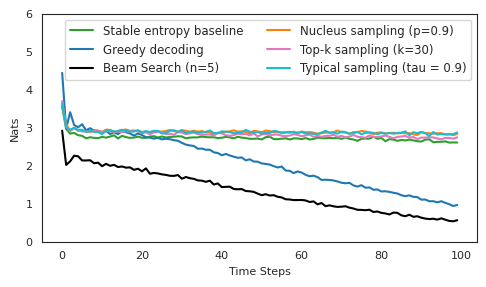

In [156]:
model_vs_human_avg_entropies = pd.concat([human_avg_entropy_pd, model_gen_greedy_avg_entropy_pd,  model_gen_beam_avg_entropy_pd, model_gen_nucleus_avg_entropy_pd, model_gen_topk_avg_entropy_pd, model_gen_typical_avg_entropy_pd],axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.drop(["Unnamed: 0"], axis=1)

model_vs_human_avg_entropies = model_vs_human_avg_entropies.rename(columns={
                                                   'human_generated_entropy': 'Stable entropy baseline',
                                                   'model_generated_greedy_entropy':'Greedy decoding', 
                                                   'model_generated_beam_entropy': 'Beam Search (n=5)',
                                                   'model_generated_nucleus_entropy': 'Nucleus sampling (p=0.9)',
                                                   'model_generated_topk_entropy': 'Top-k sampling (k=30)',
                                                   'model_generated_typical_search_entropy': 'Typical sampling (tau = 0.9)'})
figsize=(5,3)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

# plot_avg_entropies_mean_std(human_ma_entropies, ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.0, linewidth=1)
# plot_avg_entropies_mean_std(human_entropies,  ax=ax, color='tab:green', std_dev=1.0, linewidth=1.0)

styles=['tab:green', 'tab:blue', 'black', 'tab:orange', 'tab:pink', 'tab:cyan']
model_vs_human_avg_entropies.plot( 
    # title='Average Entropy vs Timesteps', 
    figsize=figsize,
    xlabel="Time Steps", 
    ylabel="Nats",
    style=styles,
    ylim=(0,6),
    ax=ax
)
plt.legend(fontsize=8.5, ncol=2)

In [ ]:
model_gen_temp_1_avg_ma_entropy_pd, model_gen_temp_1_ma_entropies = compute_average_across_sequences(model_temp_1_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_temp_1', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

NameError: name 'compute_average_across_sequences' is not defined

<AxesSubplot: >

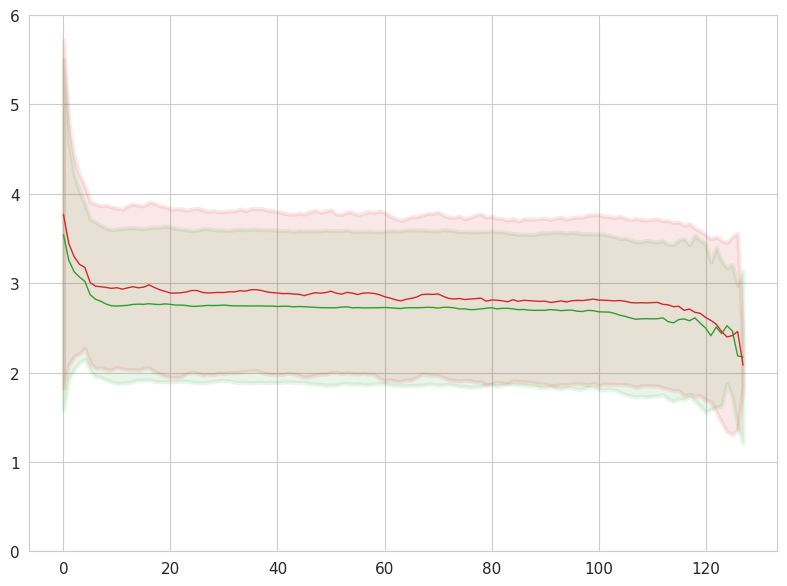

In [ ]:
figsize=(8,6)
fig, ax = plt.subplots(figsize=figsize, tight_layout=True)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=ax, color='tab:green', std_dev=1.0, linewidth=1.0)
plot_avg_entropies_mean_std(model_gen_temp_1_ma_entropies,  ax=ax, color='tab:red', std_dev=1.0, linewidth=1.0)

In [ ]:
model_gen_temp_1_avg_ma_entropy_pd, model_gen_temp_1_ma_entropies = compute_average_across_sequences(model_temp_dataframe, gpt2_model, tokenizer, column_prefix='model_generated_temp_1', width=5,  max_len=MAX_LEN, to_be_averaged="entropy_ma", num_seq=NUM_SEQ, cache=True)

# Analysis to discover entropy awareness criteria

In [ ]:

human_datapoint = human_dataframe.sample().iloc[0]
human_datapoint_idx = human_dataframe[(human_dataframe.model_text == human_datapoint.model_text)].index.item()

human_datapoint = human_dataframe.iloc[human_datapoint_idx]
greedy_sample = model_greedy_dataframe.iloc[human_datapoint_idx]
beam_sample = model_beam_dataframe.iloc[human_datapoint_idx]



Greedy Model Text: 
The first time I saw her, I was so excited. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able to hold her in my arms. I was so excited to see her, to be able 

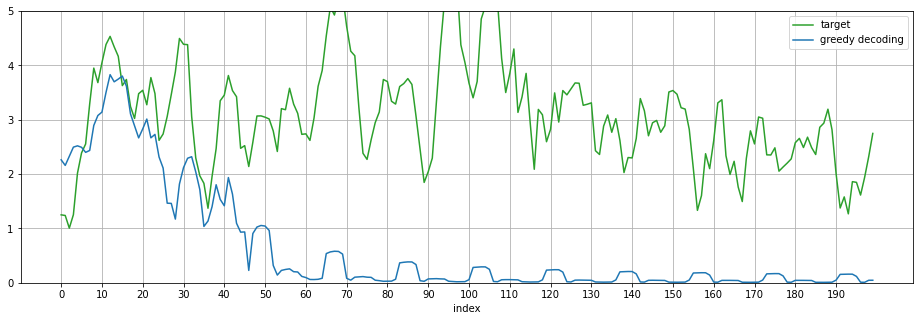

In [ ]:
fig, ax = plt.subplots(figsize=(16,5))

lpdh = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
)
lpdh['dent_cumsum'] = lpdh['dent'].cumsum()

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=greedy_sample, width=5, max_len=MAX_LEN, 
)
greedy_labeled_datapoint['dent_cumsum'] = greedy_labeled_datapoint['dent'].cumsum()

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, tokenizer=tokenizer, datapoint=beam_sample, width=5, max_len=MAX_LEN,
)
beam_labeled_datapoint['dent'] = beam_labeled_datapoint['dent'].cumsum()

# plot_avg_entropies_mean_std(human_ma_entropies[:], ax, 'human data entropy (averaged over 5 timesteps)', color='tab:green', std_dev=1.5, linewidth=0.1)
lpdh[:200].plot(x="index", y='entropy_ma', ylim=(-0,5), ax=ax, label='target', color='tab:green')


greedy_labeled_datapoint[:200].plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:blue')
# greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,5), ax=ax, label='greedy decoding', color='tab:orange')

ax.set_xticks(np.arange(len(greedy_labeled_datapoint[:200]['index']), step=10))
plt.grid()

print("Greedy Model Text: ")
print_sample(human_datapoint.context, greedy_sample.model_text.replace("\n", "<n>"))
print()

In [ ]:
greedy_labeled_datapoint['token'][20:50]

20         Ġto
21         Ġbe
22       Ġable
23         Ġto
24       Ġhold
25        Ġher
26         Ġin
27         Ġmy
28       Ġarms
29           .
30          ĠI
31        Ġwas
32         Ġso
33    Ġexcited
34         Ġto
35        Ġsee
36        Ġher
37           ,
38         Ġto
39         Ġbe
40       Ġable
41         Ġto
42       Ġhold
43        Ġher
44         Ġin
45         Ġmy
46       Ġarms
47           .
48          ĠI
49        Ġwas
Name: token, dtype: object

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = human_dataframe[human_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_greedy_dataframe[model_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_topk_dataframe[model_entropy_topk_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

num_3_gram_series = model_entropy_aware_greedy_dataframe[model_entropy_aware_greedy_dataframe.has_3_gram_repeat][["num_3_gram_repeat_length_normalized"]]
ax = num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        # rot=45,
        )

ax.legend([])

num_3_gram_series.plot.hist(
        xlim=(0, 50), 
        xticks=range(0, 51),
        yticks=np.arange(0, 10, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # logy=2,
        # label="CDF",
        # rot=45,
)
ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences with at least on 3-gram repetiion.")
fig, ax = plt.subplots()
ax2 = ax.twinx()

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        xticks=range(0, 120, 5),
        figsize=(10, 5), 
        bins=120,
        # density=1, 
        # cumulative=True,
        ax=ax,
        )

model_greedy_dataframe.num_3_gram_repeat.plot.hist(
        xlim=(0, 120), 
        # xticks=range(0, 128),
        yticks=np.arange(0, 11, 1)* 0.1,
        figsize=(10, 5), 
        bins=120,
        density=1, 
        cumulative=True,
        color='tab:orange',
        histtype='step',
        ax=ax2,
        grid=True,
        # label="CDF"
)

ax2.set_ylabel("Frequency Distribution")
ax.set_xlabel("Number of 3-Gram Repeat")
ax2.legend([])
plt.title("3-gram repeat distribution in sequences (w/o length normalization.")

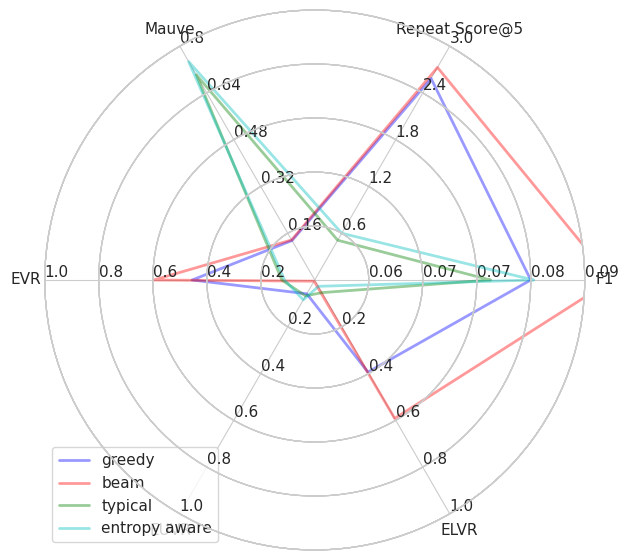

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))
        
        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


if __name__ == "__main__":
    # example data
    variables = ("F1", "Repeat Score@5", "Mauve", 
                "EVR", "EUVR", "ELVR")
    ranges = [(0.05, 0.09), (0, 3), (0, 0.8),
            (0, 1), (0, 1), (0, 1)]
    greedy = (0.082, 2.585, 0.135, 0.454, 0.059, 0.394)
    beam = (0.094, 2.727, 0.137, 0.596, 0.005, 0.592)
    typical = (0.076, 0.51, 0.702, 0.122, 0.068, 0.054)
    entropy_aware = (0.0824,0.6, 0.747, 0.112, 0.085, 0.027)
    # plotting
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, ranges)
    radar.plot(greedy,  lw=2, color="b", alpha=0.4, label="greedy")
    # radar.fill(greedy, alpha=0.2)

    radar.plot(beam,  lw=2, color="r", alpha=0.4, label="beam")
    # radar.fill(beam, alpha=0.2)

    radar.plot(typical,  lw=2, color="g", alpha=0.4, label="typical")
    # radar.fill(typical, alpha=0.2)

    radar.plot(entropy_aware,  lw=2, color="c", alpha=0.4, label="entropy aware")
    # radar.fill(entropy_aware, alpha=0.2)
    radar.ax.legend()

In [ ]:
# lpdh = process_datapoint(
#     model=gpt2_model, tokenizer=tokenizer, datapoint=human_datapoint, width=5, max_len=MAX_LEN,
# )

greedy_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=greedy_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

beam_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=beam_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

temp_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

temp_1_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_1_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
temp_1_5_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=temp_1_5_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)
nucleus_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=nucleus_sample, width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

topk_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=topk_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

typical_labeled_datapoint = process_datapoint(
    model=gpt2_model, datapoint=typical_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
)

# ead_v4_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=ead_v4_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v2_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eag_v2_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eag_v3_labeled_datapoint = process_datapoint(
#     model=gpt2_model, datapoint=eag_v3_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

# eabs_labeled_datapoint = process_datapoint(
    # model=gpt2_model, datapoint=eabs_sample,  width=5, max_len=MAX_LEN, tokenizer=tokenizer, 
# )

plt.rc('xtick', labelsize=8)    # fontsize of the tick labels
plt.rc('ytick', labelsize=8)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize
plt.rc('font', size=8)          # controls default text sizes

fig, axs = plt.subplots(2,3, figsize=(12, 3))
# plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0, 0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
# lpdh.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0,0], label='target', color='tab:green')
# axs[0,0].legend(fontsize=8, loc="upper right")
# axs[0,0].tick_params(labelsize=8)

plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[0, 0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
greedy_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 0], label='greedy decoding', color='tab:blue')
axs[0, 0].legend(fontsize=8, loc="upper right")
axs[0, 0].tick_params(labelsize=8)
axs[0, 0].set_xlabel(None)
axs[0,0].set_ylabel("Nats", fontsize=10)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0, 1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
beam_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 1], label='beam search (n=5)', color='black')
axs[0, 1].legend(fontsize=8, loc="upper right")
axs[0, 1].tick_params(labelsize=8)
axs[0, 1].set_xlabel(None)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[0, 2], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
nucleus_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[0, 2], label='nucleus sampling (p=0.9)', color='tab:orange')
axs[0, 2].legend(fontsize=8, loc="upper right")
axs[0, 2].tick_params(labelsize=8)
axs[0,2].set_xlabel(None)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1,0], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
topk_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,0], label='topk sampling (k=30)', color='tab:pink')
axs[1,0].legend(fontsize=8, loc="upper right")
axs[1,0].tick_params(labelsize=8)
axs[1,0].set_xlabel("Time Steps", fontsize=10)
axs[1,0].set_ylabel("Nats", fontsize=10)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
typical_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,1], label='typical sampling (tau=0.9)', color='tab:cyan')
axs[1,1].legend(fontsize=8, loc="upper right")
axs[1,1].tick_params(labelsize=8)
axs[1,1].set_xlabel("Time Steps", fontsize=10)

plot_avg_entropies_mean_std(human_ma_entropies,  ax=axs[1,2],  color='tab:green', std_dev=STD_DEV, linewidth=0.3)
temp_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[1,2], label='temp. sampling (temp=0.8)', color='tab:red')
axs[1,2].legend(fontsize=8, loc="upper right")
axs[1,2].tick_params(labelsize=8)
axs[1,2].set_xlabel("Time Steps", fontsize=10)

# plot_avg_entropies_mean_std(human_ma_entropies, ax=axs[3,1], color='tab:green', std_dev=STD_DEV, linewidth=0.3)
# ead_v4_labeled_datapoint.plot(x="index", y='entropy_ma', ylim=(0,6), ax=axs[3, 1], label='Entropy Aware Decoding', color='tab:olive')
# axs[3, 1].legend(fontsize=8, loc="upper right")
# axs[3, 1].tick_params(labelsize=8)

NameError: name 'process_datapoint' is not defined